In [1]:
cd ../

/Users/mattgraziano/Google Drive/repos/mlb_game_prediction


In [29]:
import pandas as pd
import numpy as np
import json

from keras import optimizers
from keras.layers import Activation, concatenate, Dense, Embedding, Input, Reshape, LSTM, TimeDistributed, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras import preprocessing

from sklearn.preprocessing import LabelEncoder

from keras.utils import to_categorical

from livelossplot import PlotLossesKeras

In [3]:
pitch = pd.read_csv('data/embedding/pitch_clean_standardize.csv')

In [4]:
pitch.head()

atbat_key  at_bat_outcome_adj_int  \
0  2008-03-25oakbos1456030430599                       4   
1  2008-03-25oakbos1456030430599                       4   
2  2008-03-25oakbos1425903430599                       3   
3  2008-03-25oakbos1425903430599                       3   
4  2008-03-25oakbos1425903430599                       3   

   atbat_outcome_fielder_location_int  general_contact_types_int  \
0                                   2                          2   
1                                   2                          2   
2                                  10                          2   
3                                  10                          2   
4                                  10                          2   

  at_bat_outcome_adj atbat_outcome_fielder_location general_contact_types  \
0             single                   center field                ground   
1             single                   center field                ground   
2                out                  third baseman                ground   
3                out                  third baseman                ground   
4                out                  third baseman                ground   

                          at_bat_outcome_description  bat_L  SL    ...     \
0  Dustin Pedroia singles on a ground ball to cen...      0   0    ...      
1  Dustin Pedroia singles on a ground ball to cen...      0   0    ...      
2  Kevin Youkilis grounds out, third baseman Jack...      0   0    ...      
3  Kevin Youkilis grounds out, third baseman Jack...      0   0    ...      
4  Kevin Youkilis grounds out, third baseman Jack...      0   0    ...      

   pitch_px  pitch_pz  pitch_vx0  pitch_vy0 pitch_vz0   pitch_x  pitch_x0  \
0      -1.0      -1.0       -1.0       -1.0      -1.0 -0.071483      -1.0   
1      -1.0      -1.0       -1.0       -1.0      -1.0 -0.095658      -1.0   
2      -1.0      -1.0       -1.0       -1.0      -1.0 -0.216814      -1.0   
3      -1.0      -1.0       -1.0       -1.0      -1.0 -0.176460      -1.0   
4      -1.0      -1.0       -1.0       -1.0      -1.0 -0.200635      -1.0   

    pitch_y  pitch_y0  pitch_z0  
0  0.025678      -1.0      -1.0  
1 -0.068076      -1.0      -1.0  
2  0.014693      -1.0      -1.0  
3  0.235221      -1.0      -1.0  
4  0.031235      -1.0      -1.0  

[5 rows x 56 columns]

In [5]:
x = np.load('data/embedding/x.npy')

y_atbat_outcomes = np.load('data/embedding/y_atbat_outcomes.npy')
y_locations = np.load('data/embedding/y_locations.npy')
y_contact_types = np.load('data/embedding/y_contact_types.npy')

x_bat_index_atbat = np.load('data/embedding/pitch_bat_index_atbat.npy')
x_pit_index_atbat = np.load('data/embedding/pitch_pit_index_atbat.npy')
x_ump_index_atbat = np.load('data/embedding/pitch_ump_index_atbat.npy')
x_park_index_atbat = np.load('data/embedding/pitch_park_index_atbat.npy')

In [6]:
# Create a hybrid outcome/location predictor
y_outcome_location = [str(outcome) + '-' + str(loc) for outcome, loc in zip(y_atbat_outcomes, y_locations)]
y_outcome_location = np.array(y_outcome_location)

encoder = LabelEncoder()
encoder.fit(y_outcome_location)

# Assign an index to each outcome
y_outcome_location = encoder.transform(y_outcome_location)

In [7]:
with open('data/embedding/y_atbat_outcomes_int_map.json', 'r') as f:
    atbat_outcome_adj_int_map = json.load(f)
with open('data/embedding/atbat_outcome_fielder_location_int_map.json', 'r') as f:
    atbat_outcome_fielder_location_int_map = json.load(f)
with open('data/embedding/general_contact_types_int_map.json', 'r') as f:
    general_contact_types_int_map = json.load(f)

In [8]:
# Create bat/pit/ump/park indexes for embedding
x_bat_index_atbat_seq = [[item]*8 for item in x_bat_index_atbat]
x_pit_index_atbat_seq = [[item]*8 for item in x_pit_index_atbat]
x_ump_index_atbat_seq = [[item]*8 for item in x_ump_index_atbat]
x_park_index_atbat_seq = [[item]*8 for item in x_park_index_atbat]

x_bat_index_atbat_seq = preprocessing.sequence.pad_sequences(x_bat_index_atbat_seq)
x_pit_index_atbat_seq = preprocessing.sequence.pad_sequences(x_pit_index_atbat_seq)
x_ump_index_atbat_seq = preprocessing.sequence.pad_sequences(x_ump_index_atbat_seq)
x_park_index_atbat_seq = preprocessing.sequence.pad_sequences(x_park_index_atbat_seq)

In [9]:
# x_bat_index_atbat_seq = preprocessing.sequence.pad_sequences(x_bat_index_atbat)
# x_pit_index_atbat_seq = preprocessing.sequence.pad_sequences(x_pit_index_atbat)
# x_ump_index_atbat_seq = preprocessing.sequence.pad_sequences(x_ump_index_atbat)
# x_park_index_atbat_seq = preprocessing.sequence.pad_sequences(x_park_index_atbat)

In [10]:
x.shape

(1855206, 8, 47)

In [11]:
atbat_outcome_adj_int_map

{'0': 'double',
 '1': 'error',
 '2': 'home_run',
 '3': 'out',
 '4': 'single',
 '5': 'strikeout',
 '6': 'triple',
 '7': 'walk',
 '8': 'walk_hbp',
 '9': 'walk_intent'}

In [12]:
atbat_outcome_fielder_location_int_map

{'0': 'NaN',
 '1': 'catcher',
 '10': 'third baseman',
 '2': 'center field',
 '3': 'first baseman',
 '4': 'left field',
 '5': 'not_fielded',
 '6': 'pitcher',
 '7': 'right field',
 '8': 'second baseman',
 '9': 'shortstop'}

In [13]:
general_contact_types_int_map

{'0': 'bunt', '1': 'fly', '2': 'ground', '3': 'line', '4': 'non_contact'}

In [14]:
NUM_BAT = len(np.unique(x_bat_index_atbat))
NUM_PIT = len(np.unique(x_pit_index_atbat))
NUM_UMP = len(np.unique(x_ump_index_atbat))
NUM_PARK = len(np.unique(x_park_index_atbat))

In [13]:
VEC_SIZE=8

NUM_OUTCOMES = len(np.unique(y_outcome_location))

bat_idx = Input(shape = (8, ), dtype = "int32", name = "bat_idx")
bat_embed = Embedding(NUM_BAT, VEC_SIZE, input_length = 8)(bat_idx)
# bat_embed = BatchNormalization()(bat_embed)

pit_idx = Input(shape = (8, ), dtype = "int32", name = "pit_idx")
pit_embed = Embedding(NUM_PIT, VEC_SIZE, input_length = 8)(pit_idx)
# pit_embed = BatchNormalization()(pit_embed)

ump_idx = Input(shape = (8, ), dtype = "int32", name = "ump_idx")
ump_embed = Embedding(NUM_UMP, VEC_SIZE, input_length = 8)(ump_idx)
# ump_embed = BatchNormalization()(ump_embed)

park_idx = Input(shape = (8, ), dtype = "int32", name = "park_idx")
park_embed = Embedding(NUM_PARK, VEC_SIZE, input_length = 8)(park_idx)
# park_embed = BatchNormalization()(park_embed)

features_input = Input(shape=(8, 47))
combined = concatenate([features_input, bat_embed, pit_embed, ump_embed, park_embed])

seq = LSTM(8, name='combined')(combined)
# seq = Dropout(.5)(seq)

output = Dense(NUM_OUTCOMES, activation = "softmax")(seq)

model = Model(inputs = [bat_idx, pit_idx, ump_idx, park_idx, features_input], outputs = [output])
sgd = optimizers.Adam()
model.compile(optimizer = sgd, loss="categorical_crossentropy", metrics=['acc'])

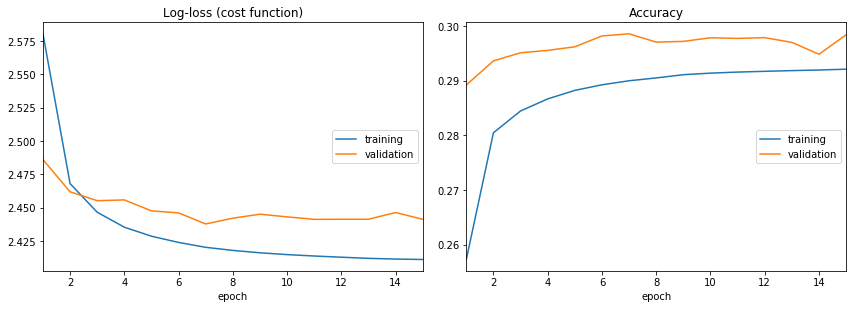

1484164/1484164 [==============================] - 218s 147us/step - loss: 2.4111 - acc: 0.2921 - val_loss: 2.4412 - val_acc: 0.2984


In [18]:
from keras.utils import to_categorical
history = model.fit([x_bat_index_atbat_seq, x_pit_index_atbat_seq, x_ump_index_atbat_seq, x_park_index_atbat_seq, x], [to_categorical(y_outcome_location)], epochs = 15, batch_size = 64, validation_split = .20, callbacks=[PlotLossesKeras()])

In [19]:
model.save('data/embedding/embedding_model.h5')

In [14]:
model = load_model('data/embedding/embedding_model.h5')

In [17]:
# Import index mappings
# PlayerID to index mappings
with open('data/embedding/index_maps/bat.json', 'r') as f:
    batter_index_dict = json.load(f)
    
with open('data/embedding/index_maps/pit.json', 'r') as f:
    pitcher_index_dict = json.load(f)
    
with open('data/embedding/index_maps/ump.json', 'r') as f:
    ump_index_dict = json.load(f)
    
with open('data/embedding/index_maps/park.json', 'r') as f:
    park_index_dict = json.load(f)
    
# Reverse dicitonaries to get index to playerid mappings
def rev_dict(in_dict):
    in_dict_rev = {v: k for k, v in in_dict.items()}
    return in_dict_rev

index_batter_dict = rev_dict(batter_index_dict)
index_pitcher_dict = rev_dict(pitcher_index_dict)
index_ump_dict = rev_dict(ump_index_dict)
index_park_dict = rev_dict(park_index_dict)

# Observations

## Embeddings size = 8
A model with only embeddings can barely break 20% accuracy

A model with only LSTM can get ~ 24%

A model with LSTM and embeddings gets nearly 30% accuracy

## Embeddings size = 2

A model with LSTM and embeddings gets ~24% accuracy

# EVALUATION

In [18]:
from keras import backend

get_bat_vec = backend.function([bat_idx], [bat_embed])
get_pit_vec = backend.function([pit_idx], [pit_embed])
get_ump_vec = backend.function([ump_idx], [ump_embed])
get_park_vec = backend.function([park_idx], [park_embed])

# Retrieve distributed representation of players.
bat_vecs = get_bat_vec([np.array([range(NUM_BAT)]*8).reshape((NUM_BAT, 8))])[0]
pit_vecs = get_pit_vec([np.array([range(NUM_PIT)]*8).reshape((NUM_PIT, 8))])[0]
ump_vecs = get_ump_vec([np.array([range(NUM_UMP)]*8).reshape((NUM_UMP, 8))])[0]
park_vecs = get_park_vec([np.array([range(NUM_PARK)]*8).reshape((NUM_PARK, 8))])[0]

#
bat_vecs_flat = [bat_vec.flatten() for bat_vec in bat_vecs]
pit_vecs_flat = [pit_vec.flatten() for pit_vec in pit_vecs]
ump_vecs_flat = [ump_vec.flatten() for ump_vec in ump_vecs]
park_vecs_flat = [park_vec.flatten() for park_vec in park_vecs]

# Save embeddings to dictionary
# Each embedding is a list of features.  Index 1 corresponds to player/ump/park of index 1
player_vecs = {"batter": bat_vecs_flat, "pitcher": pit_vecs_flat, "ump": ump_vecs_flat, "park": park_vecs_flat}

In [40]:
json.dump()

<module 'json' from '/usr/local/anaconda3/lib/python3.6/json/__init__.py'>

In [46]:
# Save embedding vectors
np.save("data/embedding/bat_embedding_vectors.npy", bat_vecs_flat)
np.save("data/embedding/pit_embedding_vectors.npy", pit_vecs_flat)
np.save("data/embedding/ump_embedding_vectors.npy", ump_vecs_flat)
np.save("data/embedding/park_embedding_vectors.npy", park_vecs_flat)

In [19]:
player_id_mapping = pd.read_csv("data/external/playerId.csv", low_memory=False)
# Player retro id to mlbid mapping
player_id_mapping = player_id_mapping[['key_mlbam', 'name_first', 'name_last', 'key_retro']]
player_id_mapping = player_id_mapping[player_id_mapping.key_mlbam.notna()].copy()
mlbid_to_retro_mapping_dict = dict(zip(player_id_mapping.key_retro, player_id_mapping.key_mlbam))
retro_to_mlbid_mapping_dict = dict(zip(player_id_mapping.key_mlbam, player_id_mapping.key_retro))

In [20]:
# Player metadata
player_meta = pd.read_csv("data/external/lahman/Master.csv")
player_meta = player_meta[['playerID',  'retroID', 'bbrefID', 'nameFirst', 'nameLast', 'bats', 'throws']]
col_mlb_id_series = [int(mlbid_to_retro_mapping_dict.get(retroID, -99999)) for retroID in player_meta.retroID]
player_meta['mlb_id'] = col_mlb_id_series

## TSNE

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
NUM_BATTERS = len(batter_index_dict.keys())
NUM_PITCHERS = len(pitcher_index_dict.keys())
NUM_UMP = len(ump_index_dict.keys())
NUM_PARK = len(park_index_dict.keys())
NUM_PLAYERS = {"batter": NUM_BATTERS, "pitcher": NUM_PITCHERS, 'ump': NUM_UMP, 'park': NUM_PARK}

def run_tsne(player_type):
    """Run t-SNE on the player vectors.

    :param player_type: 
    :return: 
    """
    params = {"batter": {"perplexity": 40, "learning_rate": 10, "init": "pca"},
              "pitcher": {"perplexity": 40, "learning_rate": 10, "init": "random"},
              "ump": {"perplexity": 40, "learning_rate": 10, "init": "random"},
              "park": {"perplexity": 40, "learning_rate": 10, "init": "random"}}
    tsne = TSNE(n_components = 3, **params[player_type])
    manifold_3d = tsne.fit_transform(player_vecs[player_type])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = "3d")
    ax.scatter(manifold_3d[:, 0], manifold_3d[:, 1], manifold_3d[:, 2], color = "gray")
    
    plt.show()

    params = {"batter": {"perplexity": 40, "learning_rate": 100, "init": "pca"},
              "pitcher": {"perplexity": 40, "learning_rate": 100, "init": "random"},
              "ump": {"perplexity": 40, "learning_rate": 100, "init": "random"},
              "park": {"perplexity": 40, "learning_rate": 100, "init": "random"}}
    tsne = TSNE(n_components = 2, **params[player_type])
    manifold_2d = tsne.fit_transform(player_vecs[player_type])
    (x, y) = (manifold_2d[:, 0], manifold_2d[:, 1])
    
    plt.scatter(x, y, color = "gray")
#     interesting_batters = {"Mike Trout", "Paul Goldschmidt", "Dee Gordon", "Ichiro Suzuki",
#                            "Bryce Harper"}
#     interesting_pitchers = {"Clayton Kershaw", "Felix Hernandez", "Madison Bumgarner",
#                             "Aroldis Chapman", "Dellin Betances"}
#     interesting_players = {"batter": interesting_batters, "pitcher": interesting_pitchers}
#     for i in range(NUM_PLAYERS[player_type]):
#         player_id = categories[player_type][i]
#         player_name = player_data[player_id]["name"]
#         if player_name in interesting_players[player_type]:
#             plt.text(x[i], y[i], player_name, va = "top", family = "monospace")

    plt.show()

    return manifold_3d



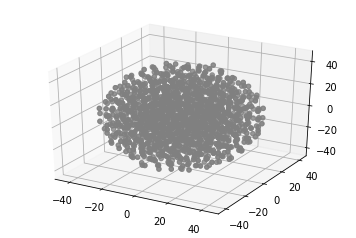

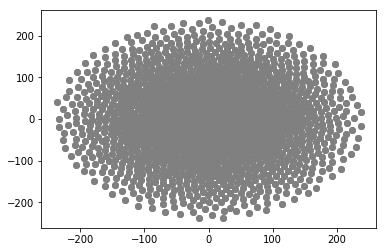

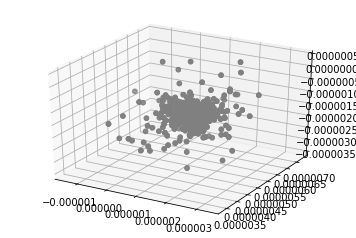

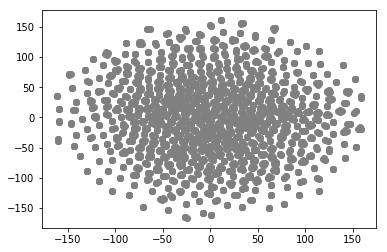

In [23]:
tsne_batters = run_tsne("batter")
tsne_pitchers = run_tsne("pitcher")

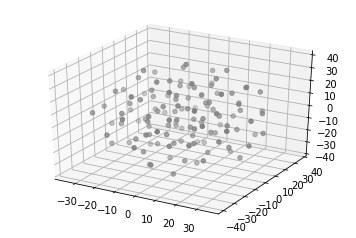

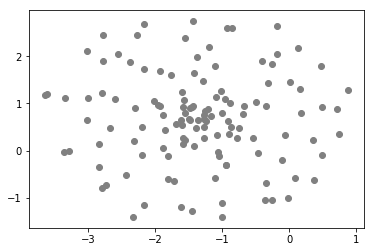

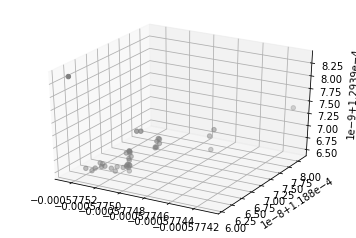

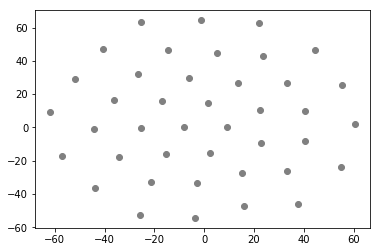

In [33]:
tsne_pitchers = run_tsne("ump")
tsne_pitchers = run_tsne("park")

In [ ]:
x_bat_index_atbat

In [ ]:
interesting_pitchers = {"Clayton Kershaw", "Felix Hernandez", "Madison Bumgarner",
                            "Aroldis Chapman", "Dellin Betances"}

In [ ]:
interesting_pitchers = {'477132', '433587', '518516', '547973', '476454'}

In [384]:
player_meta[player_meta.nameFirst == "Dellin"]

playerID   retroID    bbrefID nameFirst  nameLast bats throws  mlb_id
1264  betande01  betad001  betande01    Dellin  Betances    R      R  476454

In [ ]:
import pandas as pd


def get_nearest_neighbors(name, data, latent_vecs, player_names, k = 5):
    """Print the k nearest neighbors (in the latent space) of a given player.
    
    :param name: 
    :param data: 
    :param latent_vecs: 
    :param player_names: 
    :param k: 
    :return: 
    """
    player_index = np.where(data["name"] == name)[0]
    player_latent = latent_vecs[player_index]
    print(player_latent[0])
    # distances = list(np.linalg.norm(latent_vecs - player_latent, axis = 1))
    distances = 1 - np.dot(latent_vecs, player_latent.T).flatten() / (np.linalg.norm(latent_vecs, axis = 1) * np.linalg.norm(player_latent))
    distances_and_ids = list(zip(player_names, distances))
    distances_and_ids.sort(key = lambda x: x[1])
    
    return distances_and_ids[1:1 + k]


data_files = ["batters_latent.csv", "pitchers_latent.csv"]
player_df = {}
player_names = {}
player_ids = {}
latent_vecs = {}
for player_type in ["batter", "pitcher"]:
    data_file = "{0}s_latent.csv".format(player_type)
    player_df[player_type] = pd.read_csv(data_file)
    player_ids[player_type] = list(player_df[player_type]["player_id"])
    player_names[player_type] = list(player_df[player_type]["name"])
    latent_vecs[player_type] = np.array(player_df[player_type].iloc[:, 2:])


for batter in ["Mike Trout", "Dee Gordon"]:
    print(batter)
    print(get_nearest_neighbors(batter, player_df["batter"], latent_vecs["batter"], player_names["batter"]))
    print()

for pitcher in ["Clayton Kershaw", "Aroldis Chapman", "Jake Arrieta", "Felix Hernandez"]:
    print(pitcher)
    print(get_nearest_neighbors(pitcher, player_df["pitcher"], latent_vecs["pitcher"], player_names["pitcher"]))
    print()

# Train only embeddings (no lstm)

In [27]:
VEC_SIZE=8

NUM_OUTCOMES = len(np.unique(y_outcome_location))

bat_idx = Input(shape = (1, ), dtype = "int32", name = "bat_idx")
bat_embed = Embedding(NUM_BAT, VEC_SIZE, input_length = 1)(bat_idx)
bat_embed = Reshape((VEC_SIZE, ), name = "bat_embed")(bat_embed)

# bat_embed = BatchNormalization()(bat_embed)

pit_idx = Input(shape = (1, ), dtype = "int32", name = "pit_idx")
pit_embed = Embedding(NUM_PIT, VEC_SIZE, input_length = 1)(pit_idx)
pit_embed = Reshape((VEC_SIZE, ), name = "pit_embed")(pit_embed)

# pit_embed = BatchNormalization()(pit_embed)

ump_idx = Input(shape = (1, ), dtype = "int32", name = "ump_idx")
ump_embed = Embedding(NUM_UMP, VEC_SIZE, input_length = 1)(ump_idx)
ump_embed = Reshape((VEC_SIZE, ), name = "ump_embed")(ump_embed)

# ump_embed = BatchNormalization()(ump_embed)

park_idx = Input(shape = (1, ), dtype = "int32", name = "park_idx")
park_embed = Embedding(NUM_PARK, VEC_SIZE, input_length = 1)(park_idx)
park_embed = Reshape((VEC_SIZE, ), name = "park_embed")(park_embed)

# park_embed = BatchNormalization()(park_embed)

combined = concatenate([bat_embed, pit_embed, ump_embed, park_embed], name = "combined")

output = Dense(NUM_OUTCOMES, activation = "softmax")(combined)

model = Model(inputs = [bat_idx, pit_idx, ump_idx, park_idx], outputs = [output])
sgd = optimizers.Adam()
model.compile(optimizer = sgd, loss="categorical_crossentropy", metrics=['acc'])

In [16]:
x_park_index_atbat.shape

(1855206,)

In [17]:
x_ump_index_atbat.shape

(1855206,)

In [18]:
x_pit_index_atbat.shape

(1855206,)

In [19]:
x_bat_index_atbat.shape

(1855206,)

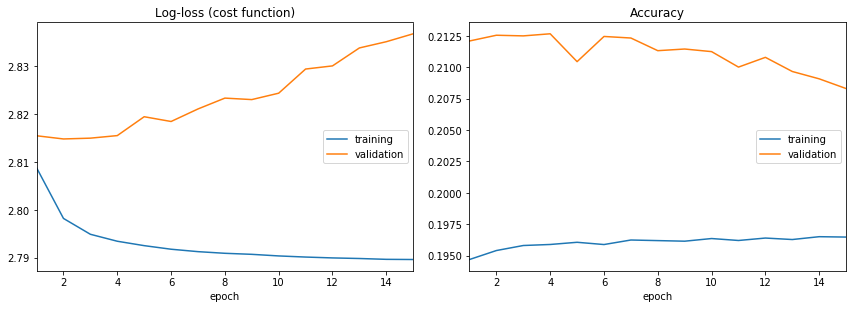

1484164/1484164 [==============================] - 46s 31us/step - loss: 2.7896 - acc: 0.1965 - val_loss: 2.8368 - val_acc: 0.2083


In [30]:
from keras.utils import to_categorical
history = model.fit([x_bat_index_atbat, x_pit_index_atbat, x_ump_index_atbat, x_park_index_atbat], [to_categorical(y_outcome_location)], epochs = 15, batch_size = 64, validation_split = .20, callbacks=[PlotLossesKeras()])

In [31]:
model.save('data/embedding/embedding_model_nolstm.h5')

In [ ]:
model = load_model('data/embedding/embedding_model_nolstm.h5')

In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bat_idx (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
pit_idx (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
ump_idx (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
park_idx (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_